In [30]:
from datetime import datetime
import random
import time

import matplotlib.pyplot as plt
import pandas as pd

import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

import numpy as np

random.seed(2)
np.random.seed(2)

# Load the Data 

In [31]:
index_file = "../dataset/pairs/perfect_broken_index.pkl"
path_broken = "../dataset/pairs/broken"
path_perfect = "../dataset/pairs/perfect"

df = pd.read_pickle(index_file)
df = df[~df["file_broken"].isnull()]
df.head()

,file_broken
file_perfect,
Bizet_Symphony_in_C_4mov_104.png,Bizet_Symphony_in_C_4mov_104Bleed_0.png
Bizet_Symphony_in_C_4mov_104.png,Bizet_Symphony_in_C_4mov_104Blur_Complete_0.png
Bizet_Symphony_in_C_4mov_104.png,Bizet_Symphony_in_C_4mov_104CharDeg_0.png
Bizet_Symphony_in_C_4mov_104.png,Bizet_Symphony_in_C_4mov_104Hole_0.png
Haendel_Concertos_Grossos_Hwv319330_op06_Concerto_Grosso_op6_n11_1mov_20.png,Haendel_Concertos_Grossos_Hwv319330_op06_Conce...


In [32]:
files_broken_perfect = df.groupby(df.index).count()
files_broken_perfect.head()

,file_broken
file_perfect,
Bach_AveMaria_0.png,4
Bach_AveMaria_1.png,4
Bach_AveMaria_2.png,4
Bach_AveMaria_3.png,4
Bach_AveMaria_4.png,4


In [33]:
files_perfect = pd.Series(files_broken_perfect.index)
files_perfect

0        Bach_AveMaria_0.png
1        Bach_AveMaria_1.png
2        Bach_AveMaria_2.png
3        Bach_AveMaria_3.png
4        Bach_AveMaria_4.png
                ...         
36797     generated_9_26.png
36798      generated_9_3.png
36799     generated_9_30.png
36800      generated_9_6.png
36801      generated_9_7.png
Name: file_perfect, Length: 36802, dtype: object

In [34]:
train_on_subset = True
subset_size = 500

if train_on_subset:
    files_perfect = files_perfect.sample(frac=1).sample(subset_size)

files_perfect.head()

8018     Bach_Concertos_Bwv1048_Brandenburg_Concert_n3_...
12143     Beethoven_Symphonies_Symphony_n2_op36_2mov_7.png
8666     Bach_Harpsichord_Concertos_Bwv1052_Harpsichord...
33843                                 generated_686_58.png
12077         Beethoven_Symphonies_Symphony_n1_4mov_83.png
Name: file_perfect, dtype: object

# Building train test and validation set

In [35]:
train_test_val = (0.9, 0.05, 0.05)
limits = [int(limit * len(files_perfect)) for limit in train_test_val]

train_dataset = files_perfect[:limits[0]]
test_dataset = files_perfect[limits[0]:limits[0] + limits[1]]
valid_dataset = files_perfect[limits[0] + limits[1]:]

train_dataset = pd.DataFrame(train_dataset)\
    .merge(df, left_on="file_perfect", right_index=True).values.tolist()

test_dataset = pd.DataFrame(test_dataset)\
    .merge(df, left_on="file_perfect", right_index=True).values.tolist()

valid_dataset = pd.DataFrame(valid_dataset)\
    .merge(df, left_on="file_perfect", right_index=True).values.tolist()

print("Sizes: train", len(train_dataset), ", test", len(test_dataset), ", validation", len(valid_dataset))

Sizes: train 1800 , test 100 , validation 100


In [36]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True)

# Train the model

In [37]:
class Denoiser(nn.Module):
    def __init__(self):
        super().__init__()
        # defining the encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        
        # defining pooling  
        self.pool = nn.MaxPool2d(2,2)
        
        # defining the decoder
        self.conv2d_1 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1)
        self.conv2d_2 = nn.Conv2d(64, 32, kernel_size=3, padding=1, stride=1)
        self.conv2d_3 = nn.Conv2d(32, 1, kernel_size=3, padding=1, stride=1)
    
    def forward(self, x):
        # passing the image through encoder 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # passing the image through encoder 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # passing the encoded part through decoder 1
        x = self.conv2d_1(x)
        x = F.relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        
        x = self.conv2d_2(x)
        x = F.relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        
        x = self.conv2d_3(x)
        
        x = F.interpolate(x, size =(3508, 2480), mode='nearest')
        
        x = F.sigmoid(x)

        return x

In [38]:
model = Denoiser()

if torch.cuda.is_available():
    print('Cuda Available..Training on GPU')
    model = model.cuda()
else:
	print('CUDA not available..Traning on CPU')

# defining the loss function
criterion = nn.MSELoss()

# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Cuda Available..Training on GPU


In [39]:
result_scale = (3508, 2480)

transform_big = transforms.Compose([
    transforms.Resize(result_scale), 
    transforms.ToTensor(), 
    transforms.Normalize(0.5, 0.5)])

transform_small = transforms.Compose([
    transforms.Resize((3508 // 2, 2480 // 2)), 
    transforms.ToTensor(), 
    transforms.Normalize(0.5, 0.5)])

def convert_perfect_image(image):
    image = Image.open(f"{path_perfect}/{image}").convert('L')
    return transform_big(image).squeeze()

def convert_broken_image(image):
    image = Image.open(f"{path_broken}/{image}").convert('L')
    return transform_small(image).squeeze()

In [40]:
epochs = 1

min_valid_loss = np.Inf

date_time = datetime.fromtimestamp(time.time())
save_file = f"save/model_{date_time.strftime('%d_%m_%Y_%H%M%S')}.pt"

print(f"Saving model to {save_file}")

training_losses = []
validation_losses = []

for epoch in range(epochs):
    print(f'\nEpoch: {epoch+1}/{epochs}')
    
    training_loss = 0
    
    for i, (files_perfect, files_broken) in enumerate(train_loader):
        print("\rTrain ", round(i/len(train_loader), 4), end="")
        
        try:
            images_perfect = torch.stack([convert_perfect_image(ip) for ip in files_perfect])
            images_broken = torch.stack([convert_broken_image(ib) for ib in files_broken])
        except Exception as e:
            print(f"Problem with {files_perfect}, {files_broken}: {str(e)}\n\n")
            continue
        
        if torch.cuda.is_available():
            images_broken, images_perfect = images_broken.cuda(), images_perfect.cuda()
        
        images_broken = images_broken.unsqueeze(1)
        images_perfect = images_perfect.unsqueeze(1)
        
        outputs = model(images_broken)
        loss = criterion(outputs, images_perfect)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
    
    training_loss = training_loss / len(train_loader)
    training_losses.append(training_loss)
    
    with torch.no_grad():
        valid_loss = 0
        
        for j, (files_perfect, files_broken) in enumerate(valid_loader):
            print("\rValid ", round(j/len(valid_loader), 4), end="")    
            try:
                images_perfect = torch.stack([convert_perfect_image(ip) for ip in files_perfect])
                images_broken = torch.stack([convert_broken_image(ib) for ib in files_broken])
            except Exception as e:
                print(f"Problem with {files_perfect}, {files_broken}: {str(e)}\n\n")
                continue
            
            if torch.cuda.is_available():
                images_broken, images_perfect = images_broken.cuda(), images_perfect.cuda()
                
                images_broken = images_broken.unsqueeze(1)
                images_perfect = images_perfect.unsqueeze(1)
            
                outputs = model(images_broken)
                loss = criterion(outputs, images_perfect)
                
                valid_loss += loss.item()
        
        valid_loss = valid_loss / len(valid_loader)
        validation_losses.append(valid_loss)    
        
        if valid_loss < min_valid_loss:
            print(f'\nLoss Decreased... ({min_valid_loss:.3f} -> {valid_loss:.3f})  Saving Model..')
            torch.save(model.state_dict(), save_file)
            min_valid_loss = valid_loss

Saving model to save/model_12_12_2023_100804.pt

Epoch: 1/1
Valid  0.9889
Loss Decreased... (inf -> 0.065)  Saving Model..


In [41]:
training_losses, validation_losses

([0.08060695113200281], [0.0652334988117218])

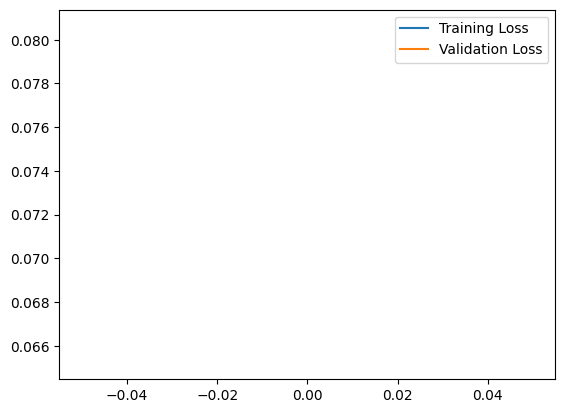

In [42]:
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend()
plt.show()

In [45]:
model = Denoiser()
model.load_state_dict(torch.load("save/model_12_12_2023_100804.pt"))
model = model.cuda()

In [46]:
for files_perfect, files_broken in test_loader:
    images_perfect = torch.stack([convert_perfect_image(i) for i in files_perfect])
    images_broken = torch.stack([convert_broken_image(i) for i in files_broken])
    
    if torch.cuda.is_available():
        images_broken = images_broken.cuda()

    tensor_predictions = model(images_broken.unsqueeze(1))
    
    for ic, ib, ip in zip(images_perfect, images_broken, tensor_predictions):
        ic = ((0.5 *  ic.numpy() + 0.5) * 255).astype(np.uint8).squeeze()
        ic = Image.fromarray(ic).convert('L')
        ic.show()
        
        ib = ((0.5 *  ib.cpu().numpy() + 0.5) * 255).astype(np.uint8).squeeze()
        ib = Image.fromarray(ib).convert('L')
        ib.show()
        
        
        ip = ((0.5 *  ip.squeeze(0).cpu().detach().numpy() + 0.5) * 255).astype(np.uint8).squeeze()
        #ip[ip < 200] = 0
        #ip[ip >= 200] = 255
        ip = Image.fromarray(ip).convert('L')
        ip.show()
        break
    
    break